# Graph Convolutional Network

* Найти графовый набор данных для решения задачи предсказания (классификация вершин, обнаружение сообществ и т.д.).* Использовать несколько слоев GCNConv из библиотеки PyG для построения GCN модели. * 
Обучить полученную модель, подобрать гиперпараметры (например, learning rate) на валидационной выборке, и оценить качество предсказания на тестовой выборк.
*  Также представить самостоятельную реализацию слоя GCNConv, используя матричные операции. Повторить обучение с собственными слоями и сравнить результаты.

In [ ]:
!pip install torch_geometric

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch import Tensor
from torch_geometric.nn import GCNConv, BatchNorm
import torch.nn.functional as F
import itertools
import torch.nn as nn

import pandas as pd
from tqdm.auto import trange
import numpy as np

In [3]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

Используем граф с цитированиями в медицинских научных статьях.

In [4]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [5]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

num_features = 500
hidden_channels = 64
num_classes = 3

model = GCN(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)

print(model)

GCN(
  (conv1): GCNConv(500, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(64, 3)
)


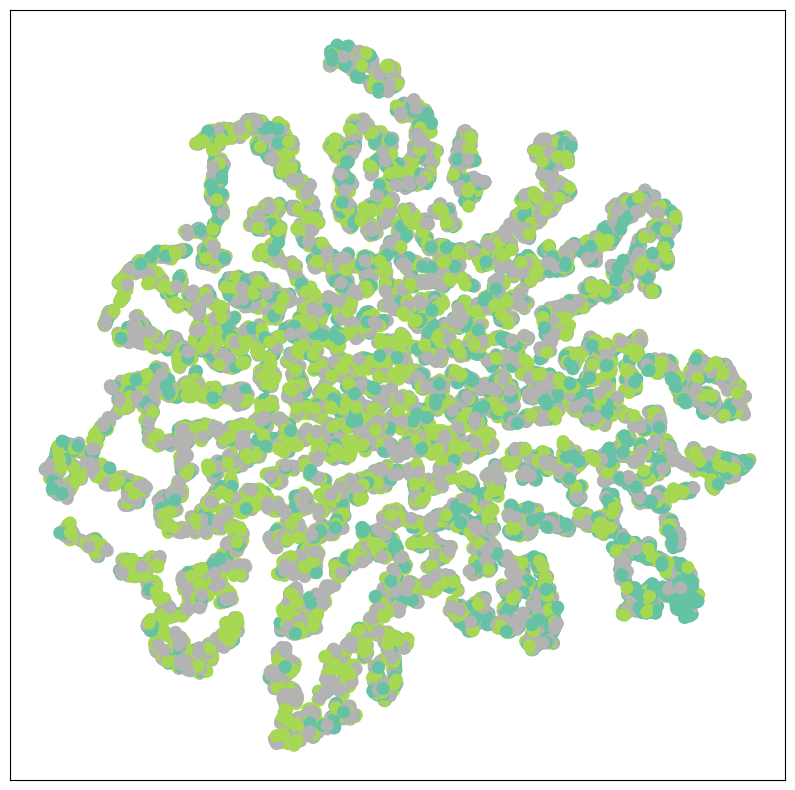

In [16]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [6]:
lrs = [0.1, 0.01, 0.001]
weight_decays = [5e-3, 5e-4, 5e-5]

best_lr = 0
best_weight_decay = 0
max_val_acc = 0

criterion = torch.nn.CrossEntropyLoss()

In [7]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    out = model(data.x, data.edge_index)
    val_pred = out.argmax(dim=1)
    correct = val_pred[data.val_mask] == data.y[data.val_mask]
    return int(correct.sum()) / int(data.val_mask.sum())

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    return int(correct.sum()) / int(data.test_mask.sum())

In [9]:
for lr, weight_decay in itertools.product(lrs, weight_decays):
    print(f"Training with lr={lr}, weight_decay={weight_decay}")

    model = GCN(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, 101):
        train()

    val_acc = validate()
    print(f"Val Accuracy: {val_acc:.4f}")

    if val_acc > max_val_acc:
        max_val_acc = val_acc
        best_lr = lr
        best_weight_decay = weight_decay

print(f"Лучшие гиперпараметры -> lr: {best_lr}, weight_decay: {best_weight_decay}, Val Accuracy: {max_val_acc:.4f}")

Training with lr=0.1, weight_decay=0.005
Val Accuracy: 0.6820
Training with lr=0.1, weight_decay=0.0005
Val Accuracy: 0.7440
Training with lr=0.1, weight_decay=5e-05
Val Accuracy: 0.7680
Training with lr=0.01, weight_decay=0.005
Val Accuracy: 0.6500
Training with lr=0.01, weight_decay=0.0005
Val Accuracy: 0.7680
Training with lr=0.01, weight_decay=5e-05
Val Accuracy: 0.7500
Training with lr=0.001, weight_decay=0.005
Val Accuracy: 0.7340
Training with lr=0.001, weight_decay=0.0005
Val Accuracy: 0.7360
Training with lr=0.001, weight_decay=5e-05
Val Accuracy: 0.7220
Лучшие гиперпараметры -> lr: 0.1, weight_decay: 5e-05, Val Accuracy: 0.7680


In [10]:
model = GCN(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

for epoch in range(1, 71):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

Epoch: 001, Loss: 1.4191
Epoch: 002, Loss: 1.3109
Epoch: 003, Loss: 0.2548
Epoch: 004, Loss: 0.2364
Epoch: 005, Loss: 0.1205
Epoch: 006, Loss: 0.0836
Epoch: 007, Loss: 0.1044
Epoch: 008, Loss: 0.0917
Epoch: 009, Loss: 0.0906
Epoch: 010, Loss: 0.0248
Epoch: 011, Loss: 0.0385
Epoch: 012, Loss: 0.0136
Epoch: 013, Loss: 0.0314
Epoch: 014, Loss: 0.0069
Epoch: 015, Loss: 0.0075
Epoch: 016, Loss: 0.0164
Epoch: 017, Loss: 0.0190
Epoch: 018, Loss: 0.0237
Epoch: 019, Loss: 0.0019
Epoch: 020, Loss: 0.0019
Epoch: 021, Loss: 0.0020
Epoch: 022, Loss: 0.0011
Epoch: 023, Loss: 0.0086
Epoch: 024, Loss: 0.0004
Epoch: 025, Loss: 0.0006
Epoch: 026, Loss: 0.0012
Epoch: 027, Loss: 0.0014
Epoch: 028, Loss: 0.0003
Epoch: 029, Loss: 0.0513
Epoch: 030, Loss: 0.0025
Epoch: 031, Loss: 0.0015
Epoch: 032, Loss: 0.0008
Epoch: 033, Loss: 0.0015
Epoch: 034, Loss: 0.0022
Epoch: 035, Loss: 0.0014
Epoch: 036, Loss: 0.0012
Epoch: 037, Loss: 0.0031
Epoch: 038, Loss: 0.0006
Epoch: 039, Loss: 0.0001
Epoch: 040, Loss: 0.0006


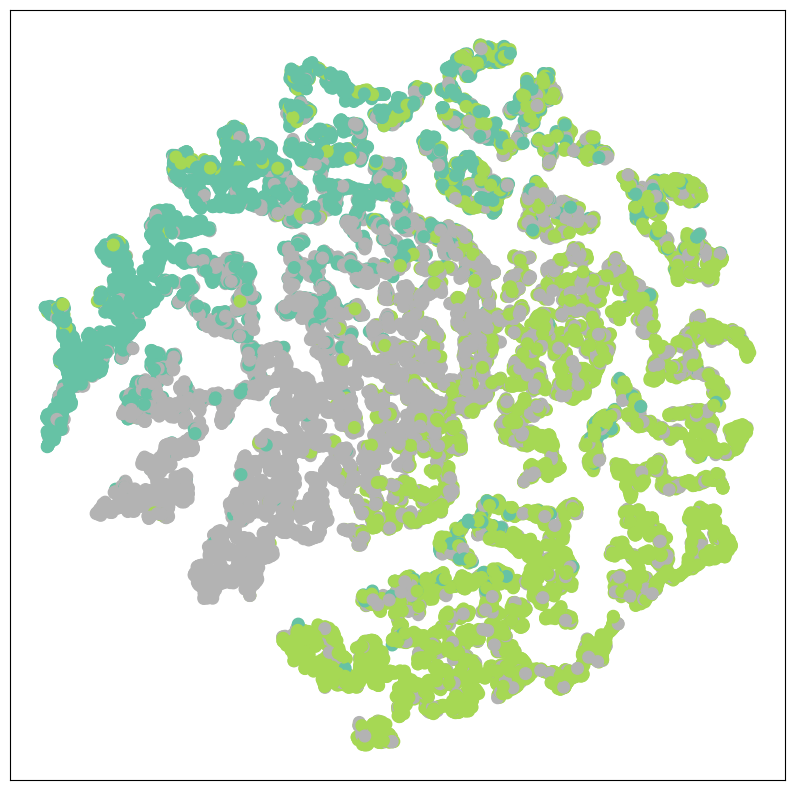

In [15]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

В результате обучения узлы на визуализации хорошо разделены на три группы, соответствующие их классам.

In [12]:
class MyGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_channels, out_channels))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

    def forward(self, x, edge_index):
        N = x.size(0)
        adj = torch.zeros((N, N), device=x.device)
        adj[edge_index[0], edge_index[1]] = 1

        adj += torch.eye(N, device=x.device)

        deg = adj.sum(dim=1)
        deg_inv_sqrt = torch.pow(deg, -0.5).clamp(min=1e-5)
        adj_norm = deg_inv_sqrt[:, None] * adj * deg_inv_sqrt[None, :]

        x = torch.matmul(x, self.weight)
        x = torch.matmul(adj_norm, x)

        if self.bias is not None:
            x = x + self.bias

        return x

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        torch.manual_seed(1234567)

        self.conv1 = MyGCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = MyGCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = MyGCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

In [14]:
model = GCN(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-05)

for epoch in range(1, 71):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

Epoch: 001, Loss: 4.4083
Epoch: 002, Loss: 1.8490
Epoch: 003, Loss: 1.5553
Epoch: 004, Loss: 0.7286
Epoch: 005, Loss: 0.2881
Epoch: 006, Loss: 0.1118
Epoch: 007, Loss: 0.0787
Epoch: 008, Loss: 0.2043
Epoch: 009, Loss: 0.0126
Epoch: 010, Loss: 0.1251
Epoch: 011, Loss: 0.0200
Epoch: 012, Loss: 0.0146
Epoch: 013, Loss: 0.1257
Epoch: 014, Loss: 0.0185
Epoch: 015, Loss: 0.0278
Epoch: 016, Loss: 0.0262
Epoch: 017, Loss: 0.0149
Epoch: 018, Loss: 0.0233
Epoch: 019, Loss: 0.0021
Epoch: 020, Loss: 0.0119
Epoch: 021, Loss: 0.0218
Epoch: 022, Loss: 0.0106
Epoch: 023, Loss: 0.0016
Epoch: 024, Loss: 0.0225
Epoch: 025, Loss: 0.0028
Epoch: 026, Loss: 0.0006
Epoch: 027, Loss: 0.0004
Epoch: 028, Loss: 0.0002
Epoch: 029, Loss: 0.0003
Epoch: 030, Loss: 0.0003
Epoch: 031, Loss: 0.0004
Epoch: 032, Loss: 0.0004
Epoch: 033, Loss: 0.0004
Epoch: 034, Loss: 0.0002
Epoch: 035, Loss: 0.0096
Epoch: 036, Loss: 0.0004
Epoch: 037, Loss: 0.0004
Epoch: 038, Loss: 0.0003
Epoch: 039, Loss: 0.0005
Epoch: 040, Loss: 0.0008


Обучение с использованием собственной реализации слоя GCN оказалось значительно более медленным по сравнению с использованием стандартного слоя GCNConv из torch_geometric, однако точность на тестовой выборке (Test Accuracy) примерно равна у обеих реализаций.